
<img alt='UCL' src="images/ucl_logo.png" align='center'>




[<img src="images/noun_post_2109127.svg" width="50" align='right'>](051_Phenology_model.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](043_Weighted_interpolation.ipynb)



# 050 Models


## Introduction

In this session, we will consider the idea of a model in (Environmental) Science and discuss some examples. The material in this section brings together a lot of the techniques we have dealt with in previous sessions, so you should make sure you are up to speed with concepts like array processing, graph plotting and writing Python functions and scripts before attempting this.

You will need to understand the material in this section to be able to complete the second half of the submitted coursework.

## Prerequisites

You will need a good understanding of previous topics involving [`np/mgrid`](031_Numpy.ipynb#np.linspace,-np.arange,-np.mgrid) and [`np.newaxis`](032_More_numpy.ipynb#Reconciling-arrays:-np.newaxis). You should by know be familiar with other more basic material. 


## Models 

We can think of a model as a 'process' box encapsulating our understanding, or a proposal for our understanding, of some process. Two examples we will cover later are:

* a descriptive model of vegetation phenology
* a model of snow-melt

Such models make an *output prediction* will be some variable, or set of variables. For our two example models, these will be:

* LAI as a function of time
* river flow resulting from snow-melt

The **outputs** depend on the mechanics of our model and:

* some set of **driving data** (in our two models this will be simply time, and time and temperature, respectively) 
* some model parameters

The model parameters control the operation of the model. These could be related to the type of vegetation for a phenology model, or terms such as the thickness of snowpack in the case of a snow-melt model. Most often, the parameters will describe *states* and *rates*, for example, the current amount of water in a snowpack (state) or the rate at which water is released from the snowpack into runoff (rate).

![model](images/parameters1.png)

We will generally have access to the driving data for our model, and we will have some set of measurements that correspond to the output, but we may not know the values of the parameters to use.

![model](images/parameters2.png)

How can we use this to provide an estimate of the model parameters? We could make some educated guesses, based on previous experience with the model in different situations ('expert opinion'), and we might also be able to provide reasonable bounds for the parameters, again either based on previous experience with the model or sometimes simply from physical limits (e.g. some parameters cannot be negative). 

What we really want is a more objective way of estimating the parameters. This involves parameter optimisation, which is a whole field of science. We cannot cover that in this course, but we can introduce some of the main ideas to use in our codes.

Before moving on to more 'realistic' models, let's build a simple example model `model` we can learn from. 

This has two parameters `p[0]` and `p[0]` and a driver that represents time:

In [1]:
# simple model 
def model(driver,param):
    '''2-parameter quadratic model with noise'''
    return param[0] + param[1] * driver * driver

We will generate a dataset `measure` at time samples `tmdriver` to represent our measurements, We generate them with the model with a set of parameters and some additive noise. We will also generate a set of weights for the observations, which we will use to indicate their reliability:

In [2]:
import numpy as np

# time driver every 4 days for measurement
tmdriver = np.arange(0,365,4,dtype=np.int)
# generate a pseudo-measurement
p0 = np.array([0.4,0.0002])
measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
# just make up some weights for this exercise
measure_weight = (2 + np.random.random(tmdriver.shape))/4
# convert to std for plotting as previously
std = 1./np.sqrt(measure_weight) * 1.96

Now we forget that we know the parameters, make a guess that they are `[0.3,0.0001]`, and use the model to make a prediction `output`. Note that `output` exists every day, whereas the measurements are only every 4 days.

measurements: tmdriver shape (92,)
model output: tdriver shape  (365,)


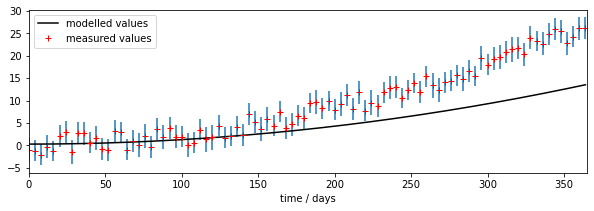

In [3]:
import matplotlib.pyplot as plt

# time driver every day
tdriver = np.arange(0,365,1,dtype=np.int)
# guess parameters
p = np.array([0.3,0.0001])
toutput  = model(tdriver,p)


# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tdriver,toutput,'k',label='modelled values')
axs.errorbar(tmdriver,measure,yerr=std,ls='none')
axs.plot(tmdriver,measure,'r+',label='measured values')
# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: tmdriver shape {tmdriver.shape}')
print(f'model output: tdriver shape  {tdriver.shape}')

We can see right away that there is a mis-match between the model outputs and the measurements.

### discrepancy and optimisation

We have a set of *observations* that correspond to the model outputs at some time samples. 

A simple operation we can do is to compare these then. We might suppose that a set of parameters that provides a lower discrepancy between observations and modelled values (we will often call this error) is *objectively better* than one with a poorer match. In that sense, what we would need to do would be to search for a set of parameters that which has the minimum error. Our search for parameters will be guided by any bounds we set. Then all we need to do is write some computer code that considers different values of the parameters and reports on the best (the optimal) match.


![model](images/parameters3.png)

That is a reasonable approach, and one we will take in these notes. We should be aware that when we do Science however, we need to take into account uncertainty, and also that there might be other constraints we want to put on the problem.

Uncertainty manifests itself at all stages of modelling and optimisation: the model itself will be uncertain, because of its nature as an abstraction of some process; the drivers will often be uncertain in their ability to the conditions at the actual place and time we are doing the modelling; and the measurements will be uncertain. We have treated uncertainty in other sections of these notes by applying a weight to observations, and we can take the same approach here. When we calculate error, for instance as the root mean square error between model predictions (output) and measurement, we can weight this to give a weighted error.

Before we can calculate the (weighted) error, we need to treat the outputs so that they match the time samples of the measurements. We can either match the observations to the measurements, or the measurements to the observations. The best approach with depend on circumstances but generally it is simplest to run the model for each observation driver. If your model involves some summation (integral) over time, then you need to think carefully about how to do this.

In this example though it is straightforward: we just run the model for the time locations that we have observations.

In [4]:
# run the model for measurement times only
tmoutput = model(tmdriver,p)
# check the shape
print(f'tmoutput shape: {tmoutput.shape}')
print(f'tmdriver shape: {tmdriver.shape}')
print(f'tdriver shape: {tdriver.shape}')

tmoutput shape: (92,)
tmdriver shape: (92,)
tdriver shape: (365,)


In [5]:
# now we can calculate the weighted discrepency 
error = (tmoutput - measure)*measure_weight
error2 = error**2
rmse = np.sqrt(np.mean(error2))
print(f'RMSE: {rmse} for parameters {p}')

RMSE: 3.958600616550031 for parameters [3.e-01 1.e-04]


measurements: measure shape  (92,)
model output: tmoutput shape (92,)


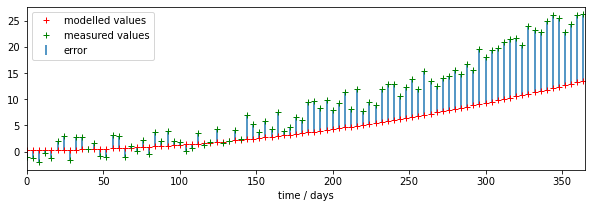

In [6]:
# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tmdriver,tmoutput,'r+',label='modelled values')
axs.plot(tmdriver,measure,'g+',label='measured values')
# plot the discrepencies as error bars using errorbar
axs.errorbar(tmdriver,measure,\
             yerr=[measure-measure,tmoutput-measure],ls='none',\
             label='error')

# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: measure shape  {measure.shape}')
print(f'model output: tmoutput shape {tmoutput.shape}')

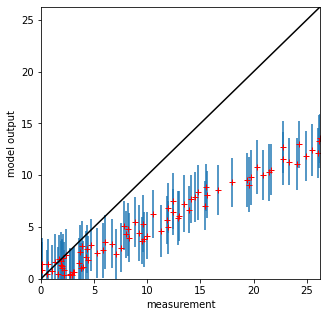

In [7]:
# scatter plot
fig, axs = plt.subplots(1,1,figsize=(5,5))
# max value over all
maxvalue = np.array([measure,tmoutput]).max()
axs.set_xlim(0,maxvalue)
axs.set_ylim(0,maxvalue)

axs.plot(measure,tmoutput,'r+')
axs.errorbar(measure,tmoutput,yerr=std,ls='none')

axs.set_ylabel(f'model output')
axs.set_xlabel(f'measurement')
# 1:1 line
axs.plot([0,maxvalue],[0,maxvalue],'k')

### Varying the parameters

We have seen how, once we have aligned the model outputs and observations, we can calculate a weighted measure if error, RMSE here. So, so some given set of measurements, a model, and a set of model parameters, we can calculate the error:

![model](images/parameters4.png)

Re-generate the set of measurements:

In [8]:
import numpy as np

# simple model 
def model(driver,param):
    '''2-parameter quadratic model with noise'''
    return param[0] + param[1] * driver * driver

# time driver every 4 days for measurement
tmdriver = np.arange(0,365,4,dtype=np.int)

# generate a pseudo-measurement
# NB different to above
p0 = np.array([0.6,0.0005])

# np.random.random(tmdriver.shape)-0.5 -> zero mean noise
measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
# just make up some weights for this exercise
measure_weight = (2 + np.random.random(tmdriver.shape))/4
# convert to std for plotting as previously
std = 1./np.sqrt(measure_weight) * 1.96

Recap on the core components so far, but setting the parameters to `numpy` arrays:

In [9]:
# some test parameters
p0,p1 = np.array([0.1]),np.array([0.2])

tmoutput  = model(tmdriver,[p0,p1])

print(f'p0 shape:    {p0.shape}')
print(f'p1 shape:    {p1.shape}')
print(f'tmdriver shape: {tmdriver.shape}')
print(f'tmoutput shape: {tmoutput.shape}')

p0 shape:    (1,)
p1 shape:    (1,)
tmdriver shape: (92,)
tmoutput shape: (92,)


We will now build a Look-up table (LUT) in parameter space to examine how the RMSE varies as we vary the model parameters.

In [10]:
import numpy as np

# Use mgrid as previously to define a 2D grid of parameters
p0min,p0max,p0step = 0.0,10.0,1
p1min,p1max,p1step = 0.0,0.0011,0.0001
p0,p1 = np.mgrid[p0min:p0max+p0step:p0step,\
                 p1min:p1max+p1step:p1step]

2d parameter grid


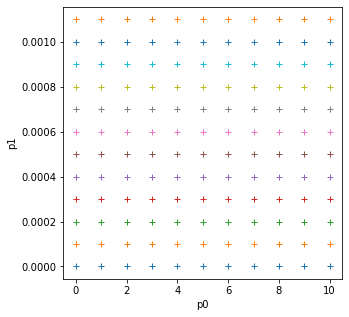

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.plot(p0,p1,'+')
axs.set_xlabel('p0')
axs.set_ylabel('p1')

print('2d parameter grid')

Recall from [032 `reshape`](032_More_numpy.ipynb#Changing-shape:-flatten,-ravel-and-reshape) that although the LUT is 2-D, we will mostly want to operate on a 1D ravelled version. So let's generate that from the outset:



In [12]:
p0_ = np.ravel(p0)
p1_ = np.ravel(p1)
print(f'shape of p0 : {p0.shape}')
print(f'shape of p0_ : {p0_.shape}')

shape of p0 : (11, 12)
shape of p0_ : (132,)




In [032 `np.newaxis`](032_More_numpy.ipynb#Reconciling-arrays:-np.newaxis) we saw how to use `np.newaxis` to reconcile two arrays for element-wise processing. Here, have the 1D arrays `tdriver` and the `p0_` and `p1_` and we want to be able to describe all parameters for all time locations;

In [13]:
p0_ext       = p0_[np.newaxis,:]
p1_ext       = p1_[np.newaxis,:]
tmdriver_ext = tmdriver[:,np.newaxis]

print(f'p0_ext shape:       {p0_ext.shape}')
print(f'p1_ext shape:       {p1_ext.shape}')
print(f'tmdriver_ext shape: {tmdriver_ext.shape}')

# we can now call the model with extended arrays
# to produce model output for all parameters and 
# time samples
tmoutput  = model(tmdriver_ext,[p0_ext,p1_ext])
print(f'tmoutput shape:     {tmoutput.shape}')

p0_ext shape:       (1, 132)
p1_ext shape:       (1, 132)
tmdriver_ext shape: (92, 1)
tmoutput shape:     (92, 132)


We need to be able to compare `tmoutput` with `measure` and `measure_weight`, so lets do that to align with the parameter grid:

In [14]:
measure_ext        = measure[:,np.newaxis]
measure_weight_ext = measure_weight[:,np.newaxis]
print(f'measure_ext shape:        {measure_ext.shape}')
print(f'measure_weight_ext shape: {measure_weight_ext.shape}')

measure_ext shape:        (92, 1)
measure_weight_ext shape: (92, 1)


We can now perform element-wise operations involving `measure_ext`, `measure_weight_ext` and `tmoutput`:

In [15]:
error_ext = (tmoutput - measure_ext)*measure_weight_ext
error_ext = error_ext*error_ext
print(f'error_ext shape: {error_ext.shape}')

error_ext shape: (92, 132)


Now calculate the square root of the mean of this squared error term `error_ext` over time samples (axis 0):

In [16]:
rmse = np.sqrt(np.mean(error_ext,axis=0))

print(f'rmse shape {rmse.shape}')
min_rmse = rmse.min()
print(f'min rmse\n{min_rmse}')

rmse shape (132,)
min rmse
0.9719539350811577


Following the material in [032](032_More_numpy.ipynb#Simplifying-shape:-flatten,-ravel,-reshape-and-unravel_index) we use `argmin` to find the parameter index of minimum RMSE:


In [17]:
# use np.argmin to find the minimum
imin = np.argmin(rmse)
p0min,p1min = p0_[imin],p1_[imin]
print(f'1D index of minimum  : {imin}')
print(f'parameter at minimum : {p0min},{p1min}')

1D index of minimum  : 5
parameter at minimum : 0.0,0.0005



To convert the index back to the unflattened array, we can use [`np.unravel_index`](032_More_numpy.ipynb#Simplifying-shape:-flatten,-ravel,-reshape-and-unravel_index) as before:

In [18]:
ip0min,ip1min = np.unravel_index(imin,p0.shape)

print(f'2D index of minimum point: {ip0min}, {ip1min}')
p0min = p0[ip0min,ip1min]
p1min = p1[ip0min,ip1min]
print(f'parameter at minimum : {p0min},{p1min}')

2D index of minimum point: 0, 5
parameter at minimum : 0.0,0.0005


Of the 11 x 12  combinations of parameters we examined, the parameters `[1.0,0.0005]` provide the best fit to the data. We had generated the 'measurements' with:

    p0 = np.array([0.6,0.0005])


#### Visualisation of RMSE

We can find it useful to visualise the RMSE 'error surface' and then plot the measurements and forward model. Since we have a flattened version, we will need to apply `reshape` before loading it. We reshape it to the same shape as `p0`:

In [19]:
# reshape to plot
_rmse = rmse.reshape(p0.shape)

Now, a graph of the RMSE values as a function of parameter 0 index. We set the maximum value in the plots below to 10 times the minimum RMSE value, as this should let us see some detail in the error function, without swamping the plot with error values that are not at all feasible. This factor of 5 is a little arbitrary, and you might need to experiment with it, but it is not a bad rule of thumb.

Text(0.5, 0, 'parameter index')

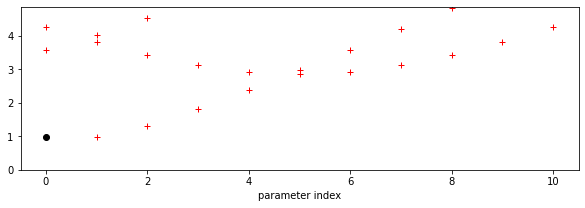

In [20]:
import matplotlib.pyplot as plt

# plot rmse as function of parameter index
pindex = np.arange(_rmse.shape[0])
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.plot(pindex,_rmse,'r+')
axs.plot([p0min],[min_rmse],'ko',label='minimum RMSE')
# set upper bound so we can see the detail
axs.set_ylim(0,min_rmse*5)
axs.set_xlabel(f'parameter index')

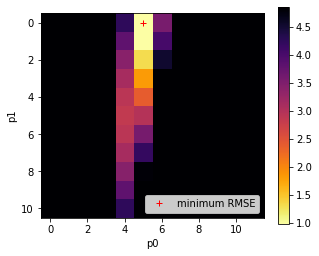

In [21]:
import matplotlib.pyplot as plt
# Plot the RMSE values returned from this as an image

# plot it
fig, axs = plt.subplots(1,1,figsize=(5,4))
# plot reshaped rmse
im = axs.imshow(rmse.reshape(p0.shape),\
                interpolation="nearest",\
                vmax=min_rmse*5,cmap=plt.cm.inferno_r)
fig.colorbar(im, ax=axs)
axs.set_xlabel('p0')
axs.set_ylabel('p1')
# notice we plot ip1min,ip0min to overlay the image
plt.plot([ip1min],[ip0min],'r+',label="minimum RMSE")
axs.legend(loc='lower right')

It is useful to look at such plots because we can use them to gauge  the uncertainty in the parameter solution. In this case, we see that the error surface is long and narrow in parameter 1. So even though we have reported the optimal value as 1.0, it could vary considerably and not change the RMSE value considerably. This is an important part of the interpretation of our results, and helps explain why we solved for a parameter value of 1.0 even though we fed the measurements with a value of 0.6.

One other thing these plots are useful for is to check that our solution does not lie on the boundary of the parameter space. Unless there is a good physical reason for the bounds we have imposed on the parameters in generating the LUT grid, if we find our solution is on a parameter boundary we might just be not sampling the parameter space well enough. Related to this, we also would like to see some spread of the RMSE values, rather than just a single low point, as this might otherwise indicate that our sampling grid is too coarse. The example above is good model for what you should be looking for the the RMSE plots, although the grid is a little coarse. Remember from above that we have thresholded the plot at 10 times the minimum RMSE so we can see the detail of the plot around the minimum point.

Now visualise the model and measurents for the 'optimum' parameters:

[0.     0.0005]
measurements: tmdriver shape (92,)
model output: tdriver shape  (365,)


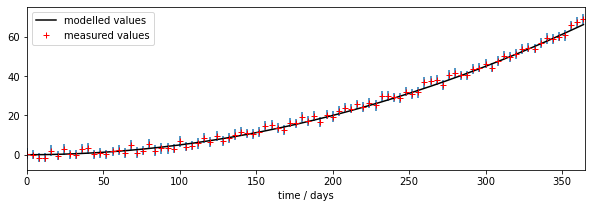

In [22]:
import matplotlib.pyplot as plt

# time driver every day
tdriver = np.arange(0,365,1,dtype=np.int)

# get the parameters we iolved for
p = np.array([p0min,p1min])
print(p)

# forward model at all time points
# noit just the measurement points
output  = model(tdriver,p)

# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tdriver,output,'k',label='modelled values')
axs.errorbar(tmdriver,measure,yerr=std,ls='none')
axs.plot(tmdriver,measure,'r+',label='measured values')
# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: tmdriver shape {tmdriver.shape}')
print(f'model output: tdriver shape  {tdriver.shape}')

The parameter estimation code is effective and quite fast in this case. 
We are using quite a sparse LUT (132 points) in 2-D, but the model is able to mimic the (pseudo) observations very well, even with rather a quantised LUT. We can see from the RMSE image plot above, and the value of RMSE we obtained, that this is likely a good solution for the model. We know from that plot also that the uncertainty in parameter 1 is high. A more sophisticated analysis would take into account the parameter uncertainty in producing the modelled outputs (i.e. put error bars on the model output).

When we forward model using the parameters we solved for, we see that the solution 
found gives a good fit to the observations, within their error bars. This further informs us
that the sensitivity to  model parameter p1 is quite low. 

### LUT inversion

This approach is called a Look-up table (LUT) inversion. It has the advantage of being quite fast if the total number of samples in the LUT can be kept down in number. This means that the limits to the problem need to be carefully considered: if your LUT inversion produces a supposed optimum parameter value that is on the bounds of the parameter space, then this can often be quite suspect: it may be that you just haven't sampled over a large-enough parameter space. The result is quantised to the LUT spacing if you use the simple approach here, but that will be fine for many applications. This is really only an appropriate method if you have a small number of parameters that you are solving for: i.e. a 1-, 2- or perhaps 3-Dimensional problem. If your model has more parameters, you may have to adopt a multi-pass strategy for parameter searching, or use a method other than LUT inversion.

#### Exercise 1

In a file `lut_RMSE.py` do the following:

        import numpy as np
        # define the min and max and step for the grid we want
        p0min,p0max,p0step = 0.0,10.0,0.05
        p1min,p1max,p1step = 0.0,0.001,0.000005

        gridp0,gridp1 = np.mgrid[p0min:p0max+p0step:p0step,\
                                 p1min:p1max+p1step:p1step]


* Write a function `gen_lut` to return a 2D parameter (Look up table -- LUT) grid using `np.mgrid` as above as `param = [gridp0,gridp1]`

        # simple model 
        def model(driver,param):
            '''2-parameter quadratic model with noise'''
            return param[0] + param[1] * driver * driver
          
* Write a function `model` to describe the model we will be using from the code above
            
        # code to use
        # time driver every 4 days for measurement    
        tmdriver = np.arange(0,365,4,dtype=np.int)
        # generate a pseudo-measurement
        p0 = np.array([5.0,0.0005])
        measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
        # just make up some weights for this exercise
        measure_weight = (2 + np.random.random(tmdriver.shape))/4
        
* Write a function `gen_meas` to generate a pseudo-measurement based on the model and some noise. It should print the value of the parameters used in the model, and return `tmdriver, measure, measure_weight` corresponding to:

        * tmdriver:       array of (Nm,) floats of the day of year on which to do modelling
        * measure:        array of (Nm,) floats of measurements over sampled days of the year
        * measure_weight: array of (Nm,) floats of the weights associated with the measurements

* Write a function `lut_RMSE` that takes as inputs:

        * `param`:          list of `[p0,p1]` with `p0` and `p1` being arrays of shape `(Np0,Np1)` representing a the LUT grid over parameter space
        * `tmdriver`:       array of (Nm,) integers: the days on which the measurements occur 
        * `measure:`        array of (Nm,) floats of measurements over sampled days of the year
        * `measure_weight`: array of (Nm,) floats of the weights associated with the measurements
    
 That runs the model `model(tmdriver,param)`, calculates the weighted RMSE between the measurements and the modelled values for each parameter pair, and returns a grid of shape `(Np0,Np1)` values of RMSE associated with each parameter pair.
 
 * Write a function `runner()` that 
    * generates tmdriver, the array of (92,) floats for every 4 day of year on which to do modelling
    * gets a LUT `param` from `gen_lut`
    * gets a pseudo-measurement from `gen_meas`
    * gets a 2-D array of RMSE corresponding to the parameter grid
    * calculated and prints the value of the parameters corresponding to the minimum RMSE,
    * returns the RMSE array, the LUT, and the measurements
 
* Run `runner()` in a notebook
* Plot the RMSE values returned from this as an image
* Verify that you have identified the minimum RMSE
* Set different parameters in `gen_meas` to generate a different pseudo-measurement and repeat the process.
* Comment on the results

In [23]:
# ANSWER
# run your own script 
!geog0111/lut_RMSE.py

/bin/bash: geog0111/lut_RMSE.py: Permission denied


In [24]:
# ANSWER
import numpy as np
# Run runner() in a notebook
from geog0111.lut_RMSE import runner, model, gen_lut
RMSE,param,(measure,measure_weight,tmdriver) = runner()

original parameters: [0.4, 0.0002]
min rmse
2.2131757282842375
index: 1447: 0.35000000000000003,0.0002
parameters: 0.35000000000000003 0.0002


In [25]:
# confirm: same as in runner?
# use argmin to find min, but need to flatten/reshape arrays first
p0,p1 = param
p0_ = np.ravel(p0)
p1_ = np.ravel(p1)
# min over time axis
imin = np.argmin(RMSE,axis=0)

print(f'index: {imin}: {p0_[imin]},{p1_[imin]}')
# back to 2D
ip0min,ip1min = np.unravel_index(imin,p0.shape)
p0min = p0[ip0min,ip1min]
p1min = p1[ip0min,ip1min]

p = np.array([p0min,p1min])
print(f'parameters: {p[0]} {p[1]}')

index: 1447: 0.35000000000000003,0.0002
parameters: 0.35000000000000003 0.0002


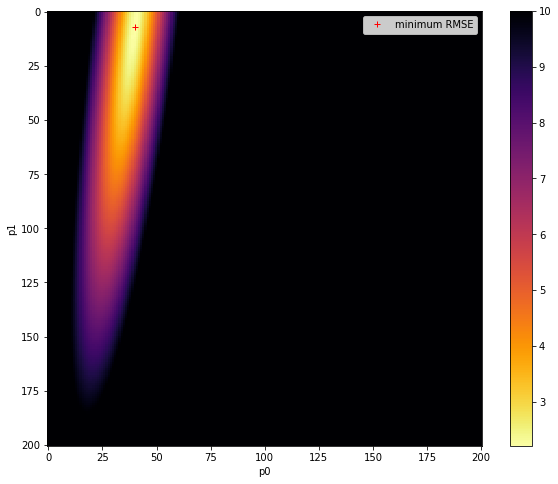

In [26]:
import matplotlib.pyplot as plt
# Plot the reshaped RMSE values returned from this as an image

# plot it
fig, axs = plt.subplots(1,1,figsize=(10,8))
im = axs.imshow(RMSE.reshape(p0.shape),interpolation="nearest",\
                vmax=10,cmap=plt.cm.inferno_r)
fig.colorbar(im, ax=axs)
axs.set_xlabel('p0')
axs.set_ylabel('p1')
plt.plot([ip1min],[ip0min],'r+',label="minimum RMSE")
axs.legend(loc='best')

original parameters: [0.7, 0.0005]
min rmse
2.2296819410044
index: 1709: 0.4,0.000505
parameters: 0.4 0.000505


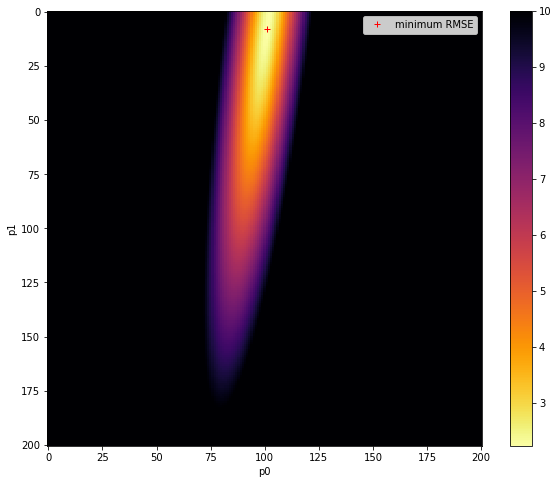

In [27]:
import numpy as np
from geog0111.lut_RMSE import gen_meas,model,lut_RMSE

# change the original parameters 
tdriver = np.arange(0,365,1,dtype=np.int)
# gets a LUT `param` from `gen_lut`
param = gen_lut()
# gets a pseudo-measurement from `gen_meas`
tmdriver,measure,measure_weight = gen_meas(p0=[0.7,0.0005])
# gets a 2-D array of RMSE corresponding to the parameter grid
RMSE = lut_RMSE(param,tmdriver,measure,measure_weight)
# calculated and prints the value of the parameters corresponding to the minimum RMSE,
min_rmse = RMSE.min()
print(f'min rmse\n{min_rmse}')

# use argmin to find min, but need to flatten/reshape arrays first
p0,p1 = param
p0_ = np.ravel(p0)
p1_ = np.ravel(p1)
# min over time axis
imin = np.argmin(RMSE,axis=0)

print(f'index: {imin}: {p0_[imin]},{p1_[imin]}')
# back to 2D
ip0min,ip1min = np.unravel_index(imin,p0.shape)
p0min = p0[ip0min,ip1min]
p1min = p1[ip0min,ip1min]

p = np.array([p0min,p1min])
print(f'parameters: {p[0]} {p[1]}')


min_rmse = RMSE.min()

fig, axs = plt.subplots(1,1,figsize=(10,8))
im = axs.imshow(RMSE.reshape(p0.shape),interpolation="nearest",\
                vmax=10,cmap=plt.cm.inferno_r)
fig.colorbar(im, ax=axs)
axs.set_xlabel('p0')
axs.set_ylabel('p1')
plt.plot([ip1min],[ip0min],'r+',label="minimum RMSE")
axs.legend(loc='best')

[0.4      0.000505]
measurements: tmdriver shape (92,)
model output: tdriver shape  (365,)


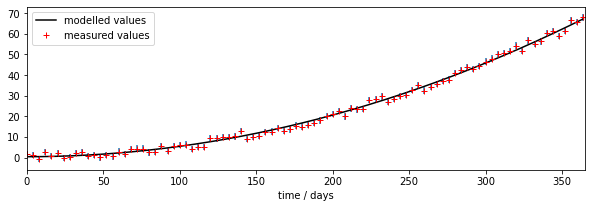

In [28]:
import matplotlib.pyplot as plt

# error bars
std = 1./np.sqrt(measure_weight) * 1.96

# time driver every day
tdriver = np.arange(0,365,1,dtype=np.int)
# get the parameters we siolved for
p = np.array([p0min,p1min])
print(p)
output  = model(tdriver,p)

# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tdriver,output,'k',label='modelled values')
axs.errorbar(tmdriver,measure,yerr=std,ls='none')
axs.plot(tmdriver,measure,'r+',label='measured values')
# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: tmdriver shape {tmdriver.shape}')
print(f'model output: tdriver shape  {tdriver.shape}')

In [29]:
# Comment on the results

msg = '''
We confirm the findings above, but are now able to see the form of the error surface in much greater detail. 
'''
print(msg)


We confirm the findings above, but are now able to see the form of the error surface in much greater detail. 



## Summary

In this notebook, we have discussed some generic aspects of models. We note that they typically have some set of driving data (even if that is just time, as in the example here), and a set of parameters that control the model response. 

We have seen how we can apply the concepts we learned in the [`numpy`](032_More_numpy.ipynb#032-More-numpy) sessions to build a parameter LUT and rapidly calculate a goodness of fit measure between some set of observations and the model output. We have seen how to use this to provide an estimate of the model parameters. This is known as model calibration. 

Technically, we have seen how we need to reconcile the dimensions of the parameter LUT and the model outputs in `numpy` using `np.newaxis` so we can calculate the model outputs for all parameters in the LUT efficiently, all at once. We have seen that parameter estimation in this way can be effective, but may be limited to a relatively small-dimensional problem. If we have a larger number of parameters, we may need to devise other strategies for parameter estimation.


[<img src="images/noun_post_2109127.svg" width="50" align='right'>](051_Phenology_model.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](043_Weighted_interpolation.ipynb)

